In [ ]:
#Reference: SimpleITK documentation: https://simpleitk.readthedocs.io/en/master/

In [1]:
import SimpleITK as sitk
from downloaddata import fetch_data as fdata
%matplotlib notebook
import gui
import registration_gui as rgui

import numpy as np
import os
OUTPUT_DIR = 'output'

<IPython.core.display.Javascript object>


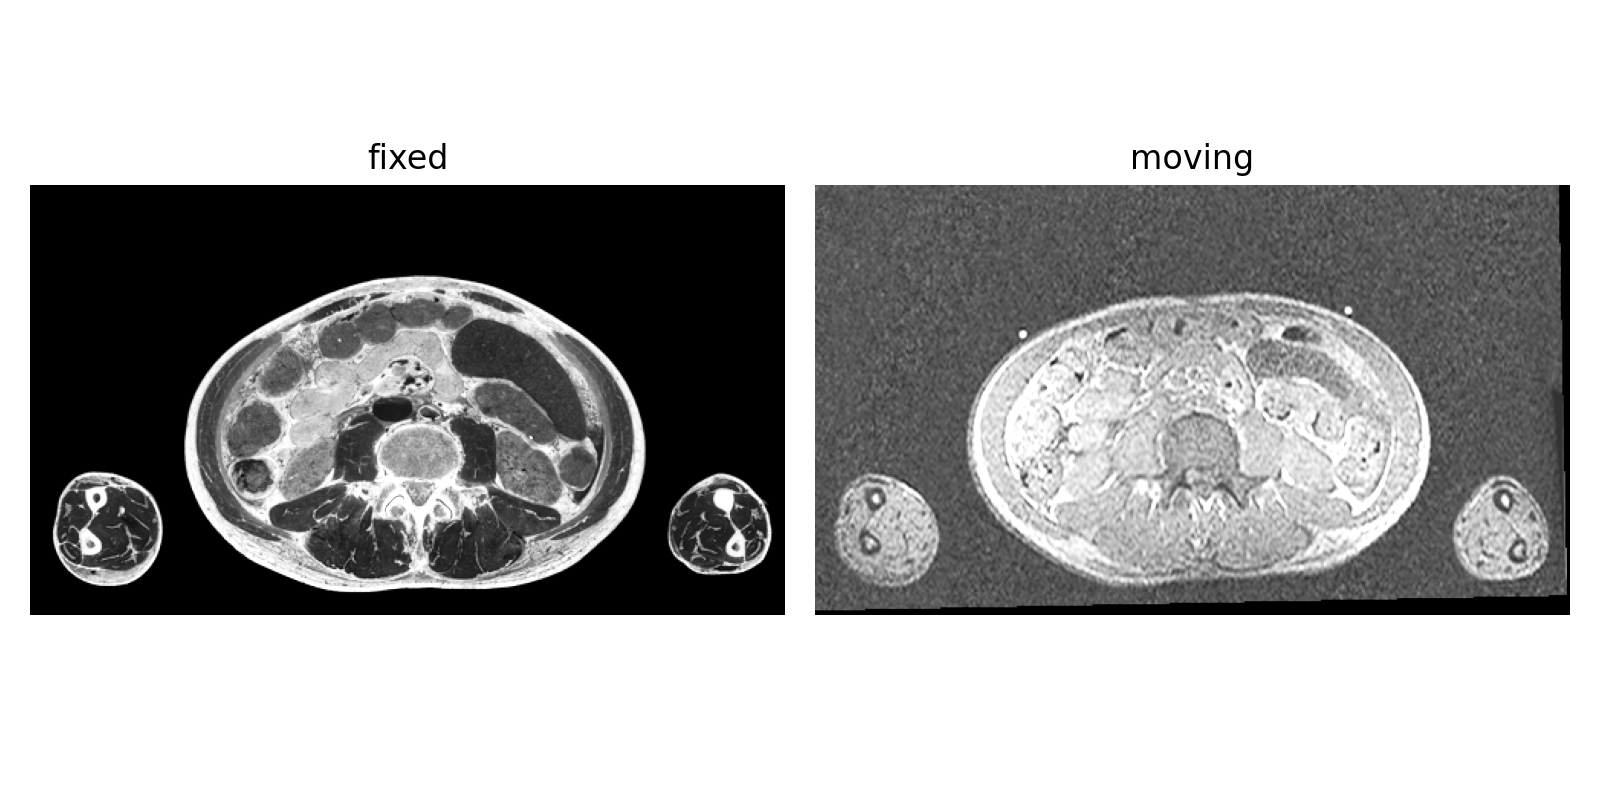

In [2]:
fixed_image =  sitk.ReadImage("/Users/pronomabanerjee/Desktop/subvolumes_abdomen/cryocleaned_abdomen_padded.mhd", sitk.sitkFloat32)
#moving_image = sitk.ReadImage("/Users/pronomabanerjee/Desktop/subvolumes_abdomen/CT_abdomen.mhd", sitk.sitkFloat32)
moving_image = sitk.ReadImage("/Users/pronomabanerjee/Desktop/subvolumes_abdomen/TUTORIAL/output/MRI_transformed_SITK1.mhd", sitk.sitkFloat32)

ct_window_level = [835,162]
mr_window_level = [1036,520]

gui.MultiImageDisplay(image_list = [fixed_image, moving_image],                   
                      title_list = ['fixed', 'moving'], figure_size=(8,4), window_level_list=[ct_window_level, mr_window_level]);

In [6]:
def command_iteration(filter):
    print(f"{filter.GetElapsedIterations():3} = {filter.GetMetric():10.5f}")


'''if len(sys.argv) < 4:
    print(
        f"Usage: {sys.argv[0]} <fixedImageFilter> <movingImageFile> <outputTransformFile>")
    sys.exit(1)'''

fixed = fixed_image

moving = moving_image

matcher = sitk.HistogramMatchingImageFilter()
matcher.SetNumberOfHistogramLevels(1024)
matcher.SetNumberOfMatchPoints(7)
matcher.ThresholdAtMeanIntensityOn()
moving = matcher.Execute(moving, fixed)

# The basic Demons Registration Filter
# Note there is a whole family of Demons Registration algorithms included in
# SimpleITK
#demons = sitk.DemonsRegistrationFilter()
demons = sitk.DiffeomorphicDemonsRegistrationFilter()
demons.SetNumberOfIterations(50)
# Standard deviation for Gaussian smoothing of displacement field
demons.SetStandardDeviations(1.0)

demons.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(demons))

displacementField = demons.Execute(fixed, moving)

print("-------")
print(f"Number Of Iterations: {demons.GetElapsedIterations()}")
print(f" RMS: {demons.GetRMSChange()}")

outTx = sitk.DisplacementFieldTransform(displacementField)

sitk.WriteTransform(outTx, os.path.join(OUTPUT_DIR, "detailsdeform1mri.tfm"))

  1 = 1955.17121
  2 = 1848.01853
  3 = 1789.48534
  4 = 1749.58136
  5 = 1719.63792
  6 = 1695.94832
  7 = 1676.57089
  8 = 1660.30596
  9 = 1646.34430
 10 = 1634.16153
 11 = 1623.37168
 12 = 1613.78916
 13 = 1605.02259
 14 = 1596.97856
 15 = 1589.57525
 16 = 1582.74889
 17 = 1576.59067
 18 = 1570.60967
 19 = 1564.89773
 20 = 1559.47960
 21 = 1554.31311
 22 = 1549.40137
 23 = 1544.72588
 24 = 1540.52951
 25 = 1536.48851
 26 = 1532.45131
 27 = 1528.55476
 28 = 1524.79286
 29 = 1521.17081
 30 = 1517.69793
 31 = 1514.35518
 32 = 1511.15883
 33 = 1508.38586
 34 = 1505.54651
 35 = 1502.68235
 36 = 1499.90630
 37 = 1497.22653
 38 = 1494.61221
 39 = 1492.07935
 40 = 1489.63608
 41 = 1487.34744
 42 = 1485.15077
 43 = 1483.16461
 44 = 1481.03258
 45 = 1478.92572
 46 = 1476.98586
 47 = 1475.28586
 48 = 1473.77181
 49 = 1472.12081
 50 = 1470.44176
-------
Number Of Iterations: 50
 RMS: 0.21839280684644166


In [7]:
if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    #simg1 = sitk.Cast(sitk.RescaleIntensity(moving), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    # Use the // floor division operator so that the pixel type is
    # the same for all three images which is the expectation for
    # the compose filter.
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)

<IPython.core.display.Javascript object>


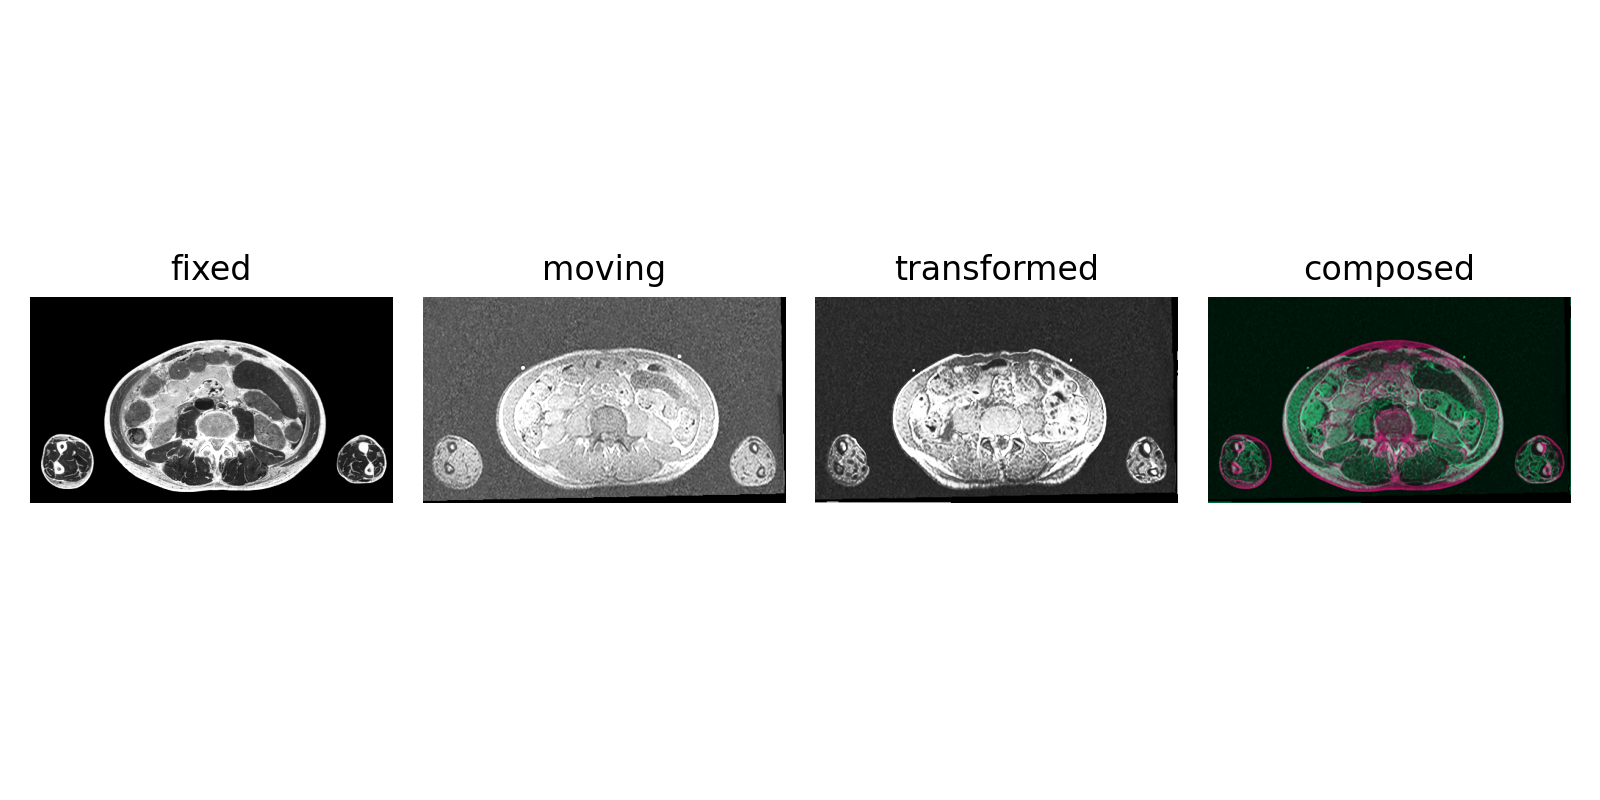

<IPython.core.display.Javascript object>


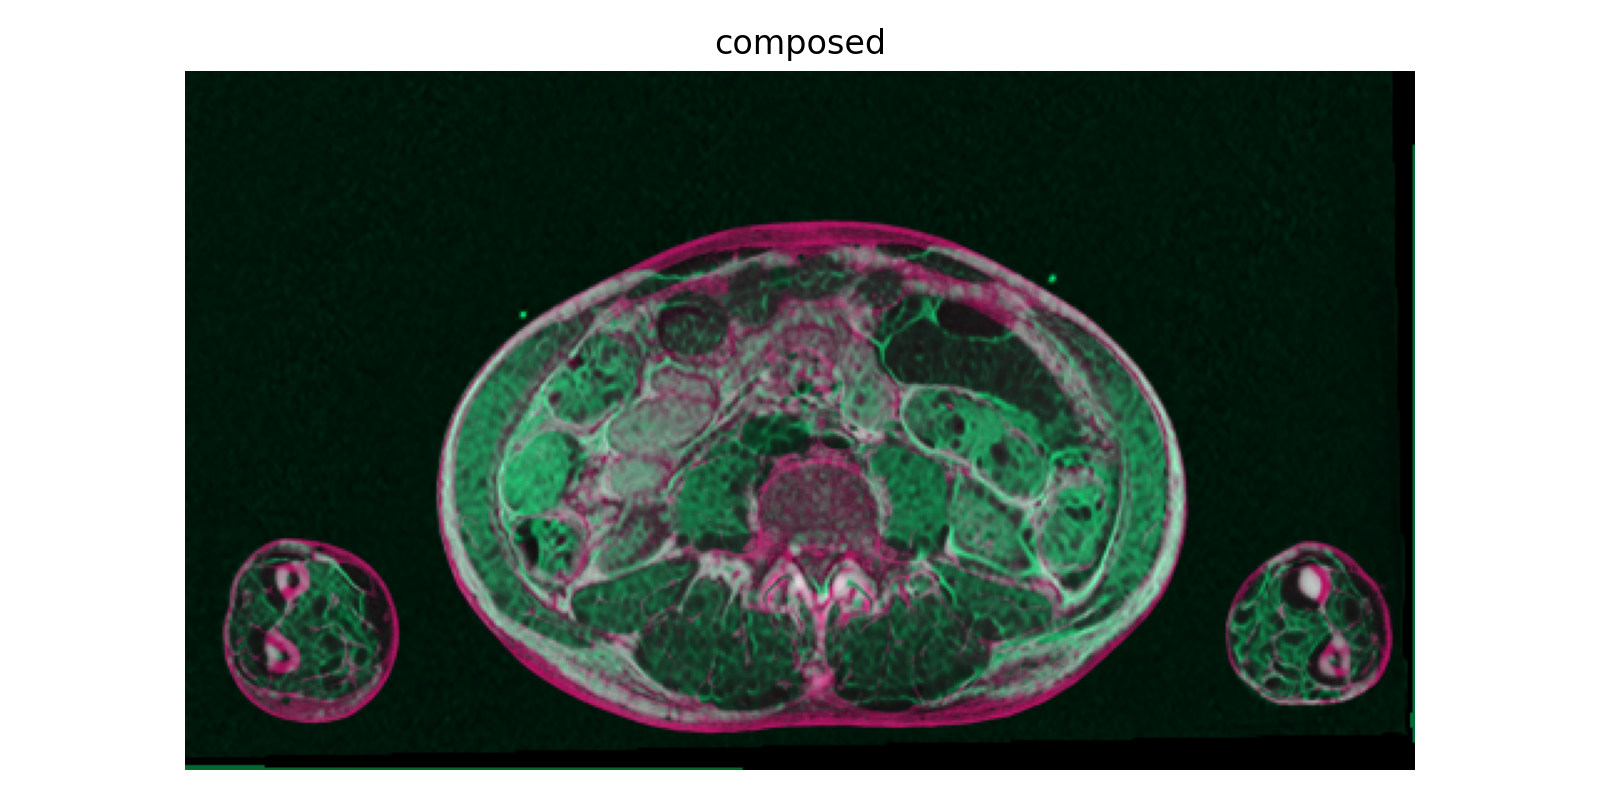

In [9]:
gui.MultiImageDisplay(image_list = [fixed_image, moving_image, out, cimg],                   
                      title_list = ['fixed', 'moving', 'transformed', 'composed'], figure_size=(8,4));


gui.MultiImageDisplay(image_list = [cimg],                   
                      title_list = ['composed'], figure_size=(8,4));



In [10]:
sitk.WriteImage(out, os.path.join(OUTPUT_DIR, "MRI_diffeodemonsafterrigid.mhd"))